# Example: Deploying a Classifier
This notebook shows how one might use a previously trained model to classify a subset of the ISBI 2012 data set.  This assumes you have a local copy of the ISBI 2012 data (available from the [ISBI challenge website](http://brainiac2.mit.edu/isbi_challenge/home)) and access to a file containing trained weights (one example weights file is checked into this repository).  You will also need to have [Keras](http://keras.io/) (along with a suitable backend) installed.

---

## Step 1: setup python environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, copy, logging

# pick up local libraries
sys.path.append(os.path.join('..', 'src'))
sys.path.append(os.path.join('..', 'src', 'thirdparty'))

import numpy as np
import pylab as plt

import emlib
import models as emm
from deploy import deploy_model


try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_model")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

Using Theano backend.
/Users/graywr1/.conda/envs/ndparse2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Step 2: Load data and model weights

This example uses the ISBI 2012 test volume as the input to the CNN.  One could replace this with a different file, or perhaps an API call to some neuro database [e.g. see here for some good examples](https://github.com/neurodata/kasthuri2015/blob/master/claims/claim0_get_data.ipynb).

Test data shape is: (30, 1, 512, 512)


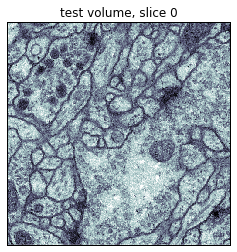

In [3]:
# Load previously trained weights and data volume(s).
weightsFile = '../Models/ISBI2012/weights_epoch_025.h5'

# TODO: Pull using ndio
Xtrain = emlib.load_cube('../data/ISBI2012/train-volume.tif')
Ytrain = emlib.load_cube('../data/ISBI2012/train-labels.tif')
Xtest = emlib.load_cube('../data/ISBI2012/test-volume.tif')

# show some details.  Note that data tensors are assumed to have dimensions:
#   (#slices, #channels, #rows, #columns)
#
print('Test data shape is: %s' % str(Xtest.shape))
plt.imshow(Xtest[0,0,...], interpolation='none', cmap='bone')
plt.title('test volume, slice 0')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

## Step 3: Deploy the model

In [4]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* we will only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
P0 = deploy_model(Xtest, weightsFile, slices=[0,], evalPct=.1, log=logger)

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
# While it is redundant to return both class estimates for binary classification
# problems (one estimate is just 1.0 minus the other) we keep the extra data
# for consistency with multi-class problems.
print('Class probabilities shape: %s' % str(P0.shape))

[2016-03-30 11:58:01,403:deploy_model:WARNING]  No output file specified - are you sure this is what you want?
[2016-03-30 11:58:01,407:deploy_model:INFO]  X volume dimensions: (1, 1, 512, 512)
INFO:deploy_model:X volume dimensions: (1, 1, 512, 512)
[2016-03-30 11:58:01,424:deploy_model:INFO]  X values min/max:    0, 1
INFO:deploy_model:X values min/max:    0, 1
[2016-03-30 11:58:01,427:deploy_model:INFO]  initializing CNN...
INFO:deploy_model:initializing CNN...
[2016-03-30 11:59:46,827:deploy_model:INFO]  evaluating volume...
INFO:deploy_model:evaluating volume...
[2016-03-30 11:59:47,400:deploy_model:INFO]  after masking, will evaluate 10.00% of data
INFO:deploy_model:after masking, will evaluate 10.00% of data
[2016-03-30 11:59:50,032:deploy_model:INFO]    last pixel [  0   1 473] (0.38% complete)
INFO:deploy_model:  last pixel [  0   1 473] (0.38% complete)
[2016-03-30 12:01:51,515:deploy_model:INFO]    last pixel [  0 111 163] (21.74% complete)
INFO:deploy_model:  last pixel [  0

Class probabilities shape: (1, 2, 512, 512)


In [30]:
# (Optional) It may also be instructive to visualize performance on (a subset of) the training data.
Ptrain = deploy_model(Xtrain, weightsFile, slices=range(0,10), evalPct=.1, log=logger)
print('Class probabilities shape: %s' % str(Ptrain.shape))

[2016-03-21 12:03:15,137:deploy_model:WARNING]  No output file specified - are you sure this is what you want?
[2016-03-21 12:03:15,162:deploy_model:INFO]  X volume dimensions: (10, 1, 512, 512)
INFO:deploy_model:X volume dimensions: (10, 1, 512, 512)
[2016-03-21 12:03:15,166:deploy_model:INFO]  X values min/max:    0, 1
INFO:deploy_model:X values min/max:    0, 1
[2016-03-21 12:03:15,167:deploy_model:INFO]  initializing CNN...
INFO:deploy_model:initializing CNN...
[2016-03-21 12:03:41,670:deploy_model:INFO]  evaluating volume...
INFO:deploy_model:evaluating volume...
[2016-03-21 12:03:43,064:deploy_model:INFO]  after masking, will evaluate 10.00% of data
INFO:deploy_model:after masking, will evaluate 10.00% of data
[2016-03-21 12:03:43,182:deploy_model:INFO]    last pixel [  0   1 473] (0.04% complete)
INFO:deploy_model:  last pixel [  0   1 473] (0.04% complete)
[2016-03-21 12:05:43,230:deploy_model:INFO]    last pixel [  8 238  90] (84.65% complete)
INFO:deploy_model:  last pixel [ 

Class probabilities shape: (10, 2, 512, 512)


## Step 4: Postprocessing

Note: in order to do actual science, one would probably use more sophisticated postprocessing (and also put more effort into the CNN design).

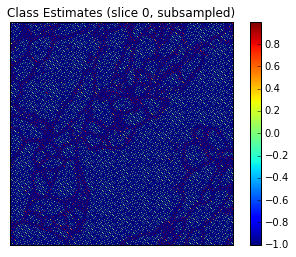

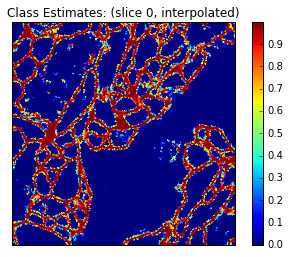

In [5]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
Pint = emlib.interpolate_nn(P0)

# visualize
plt.imshow(P0[0,0,...]); plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.title('Class Estimates (slice 0, subsampled)')
plt.show()

plt.imshow(Pint[0,0,...]); plt.colorbar()
plt.title('Class Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()


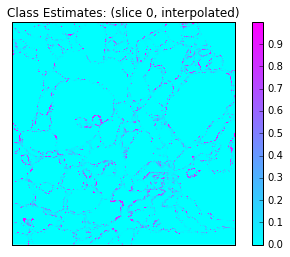

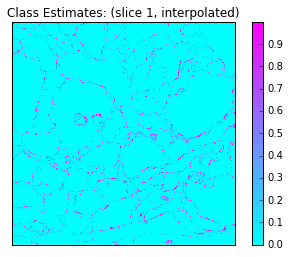

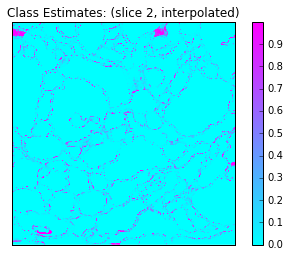

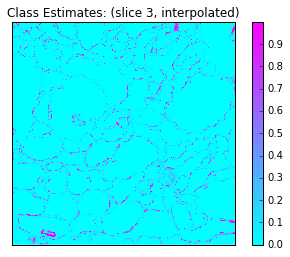

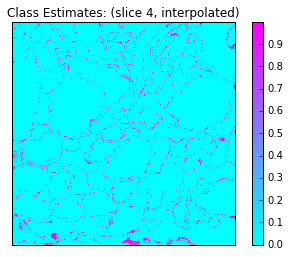

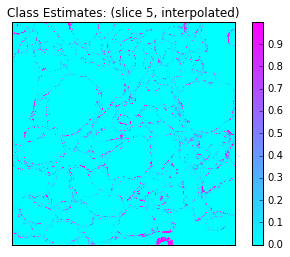

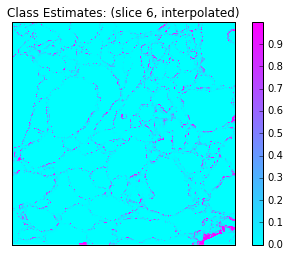

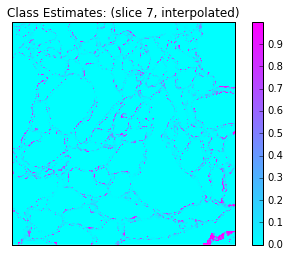

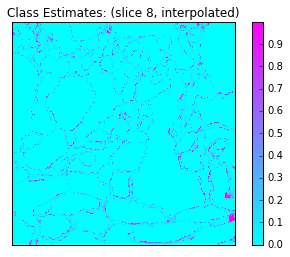

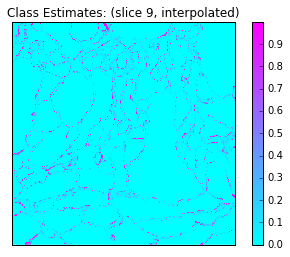

In [29]:
# Visualize where the classifier is making mistakes on the training data.
PtrainInt = emlib.interpolate_nn(Ptrain)
Ytrue = np.zeros(Ytrain.shape)
Ytrue[Ytrain==0] = 1;
Ytrue[Ytrain>0] = 0;

for ii in range(PtrainInt.shape[0]):
    Img = Ytrue[ii,...] - PtrainInt[ii,0,...]
    Img = np.squeeze(Img)
    Img[Img < 0] = 0;  # for now, focus on "false negatives"
    
    plt.imshow(Img, cmap='cool', interpolation='none'); plt.colorbar()
    plt.title('Class Estimates: (slice %d, interpolated)' % ii)
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])
    plt.show()

### Notes
It helps to have a reasonably good GPU when running this example.  e.g. I run this notebook remotely on our GPU cluster using the instructions provided [here](http://www.datasciencebytes.com/bytes/2015/12/18/using-jupyter-notebooks-securely-on-remote-linux-machines/).

On the cluster, navigate to the toplevel directory of this repository and do:
```
    jupyter notebook --no-browser &
```

On the local machine, establish an ssh session:
```
    ssh -i ~/.ssh/redd-gpucluster.pekalmj1.rsa -NL 8157:localhost:8888 pekalmj1@gpucluster0
```

On the local machine, point browser to:
```
    http://localhost:8157
```